In [134]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [27]:
cost_benefit = np.array([[0.0, -22.50], [-27.50, -15.0]])

def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 0 is the positive class'''
    return np.where(model.predict_proba(X)[:, 1] > threshold,
                    model.classes_[1],
                    model.classes_[0])

def confusion_matrix(model, X, y, threshold=0.5):
    cf = pd.crosstab(y, predict(model, X, threshold))
    cf = cf.rename(columns={0:'Not', 1:'Fraud'}, index={0:'Not', 1:'Fraud'})
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

def total_cost(predicted, cb=cost_benefit):
    cost = predicted*cb
    return cost.values.sum()

def print_results(X, y, model, threshold=.1, p=True):
    if p:
        yhat = predict(model, X, threshold)
    else:
        yhat = model.predict(X)
    tn, fp, fn, tp = metrics.confusion_matrix(y, yhat).flatten()
    print ('  TP  |  FN  |  FP  |  TN  ')
    print ('--------------------------')
    print(f'{tp:6d}|{fn:6d}|{fp:6d}|{tn:6d}')
    print ('--------------------------')
    recall = metrics.recall_score(y, yhat)
    roc = metrics.roc_auc_score(y, yhat)
    precision = metrics.precision_score(y, yhat)
    print(f'Recall:     {recall:0.4g}')
    print(f'Precision:  {precision:.4f}')
    print(f'ROC_AUC:    {roc:.4f}')


In [49]:
X_train, X_test, y_train, y_test = train_test_split(df.values, y.values, random_state=7, stratify=y.values)

In [50]:
X_spr_train, X_spr_test = csr_matrix(X_train), csr_matrix(X_test)

In [29]:
xgb = XGBClassifier(booster='dart', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=1, gamma=0,
                    learning_rate=0.05, max_delta_step=0, max_depth=3,
                    min_child_weight=1, n_estimators=300, n_jobs=-1, base_score=.5,
                    random_state=2, reg_alpha=0, reg_lambda=1, scale_pos_weight=30)

In [66]:
booster = xgb.fit(X_train, y_train, eval_metric='logloss')

In [67]:
print ('Training Data | Voting Classifier')
print_results(X_train, y_train, booster, p=False)
print ('')
print ('Testing  Data | Voting Classifier')
print_results(X_test, y_test, booster, p=False)

Training Data | Voting Classifier
  TP  |  FN  |  FP  |  TN  
--------------------------
   151|   346|  1226| 16894
--------------------------
Recall:     0.3038
Precision:  0.1097
ROC_AUC:    0.6181

Testing  Data | Voting Classifier
  TP  |  FN  |  FP  |  TN  
--------------------------
    22|   191|   570|  7196
--------------------------
Recall:     0.1033
Precision:  0.0372
ROC_AUC:    0.5149


In [60]:
df = pd.read_pickle('data/dummy_train.pkl')
target = df.pop('fraud')

In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df = df[df.amount != 0]
df.reset_index(drop=True, inplace=True)

In [6]:
df.drop(columns=['total','hour2','state1','custAttr2'], inplace=True)
y = df.pop('fraud')

In [198]:
#cv_ = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#scores = cross_val_score(booster, X_train, y_train, scoring='roc_auc', cv=cv_, n_jobs=-1)
#print('Mean ROC AUC: %.3f' % np.mean(scores))

In [14]:
def OHC(df, features):
    encoder = OneHotEncoder(drop='first', sparse=False)
    for feature in features:
        dummies = encoder.fit_transform((df[feature].values).reshape(-1,1))
        dummies = pd.DataFrame(dummies, columns=encoder.get_feature_names())
        df = df.drop(columns=feature).join(dummies)
        df.replace(np.nan, 0, inplace=True)
        print ('done')
    return df
X = OHC(df, ['account_id'])
X

In [15]:
X = csr_matrix(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=7, test_size=.3, stratify=target)

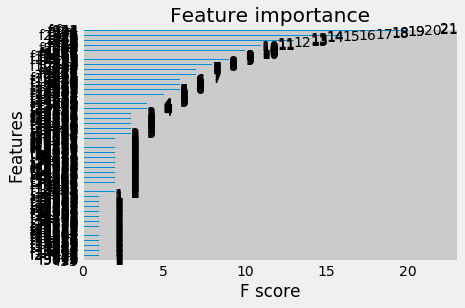

In [74]:
fig, ax = plt.subplots()
xgboost.plot_importance(xgb, ax=ax)

#### TUNING MAX DEPTH

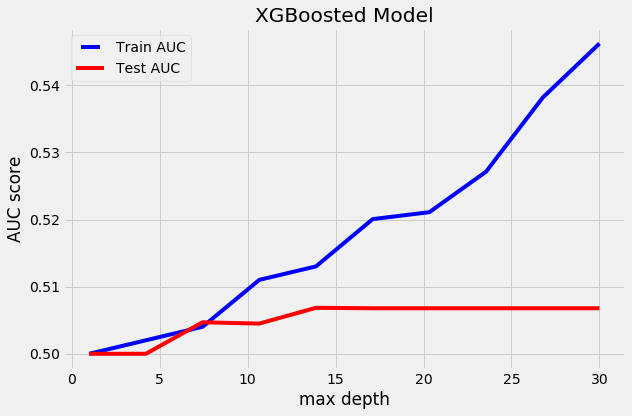

In [84]:
max_depths = np.linspace(1, 30, 10, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    xgb = XGBClassifier(max_depth=int(max_depth))
    xgb.fit(X_train, y_train)
    train_pred = xgb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = xgb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(figsize=(9, 6))
line1, = ax.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = ax.plot(max_depths, test_results, 'r', label='Test AUC')
ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax.set_title('XGBoosted Model')
ax.set_ylabel('AUC score')
ax.set_xlabel('max depth')
fig.tight_layout()
plt.savefig('visuals/XGBdepths.png')

#### TUNING WEIGHT

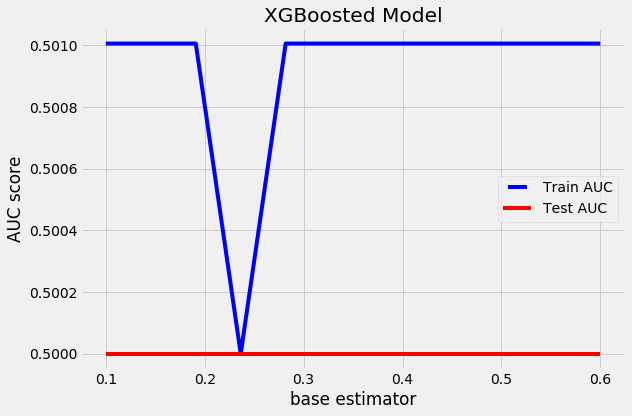

In [83]:
weights = np.linspace(.1, .6, 12, endpoint=True)
train_results = []
test_results = []
for weight in weights:
    xgb = XGBClassifier(base_score=weight)
    xgb.fit(X_train, y_train)
    train_pred = xgb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = xgb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(figsize=(9, 6))
line1, = ax.plot(weights, train_results, 'b', label='Train AUC')
line2, = ax.plot(weights, test_results, 'r', label='Test AUC')
ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax.set_title('XGBoosted Model')
ax.set_ylabel('AUC score')
ax.set_xlabel('base estimator')
fig.tight_layout()
plt.savefig('visuals/XGBestimator.png')

#### TUNING

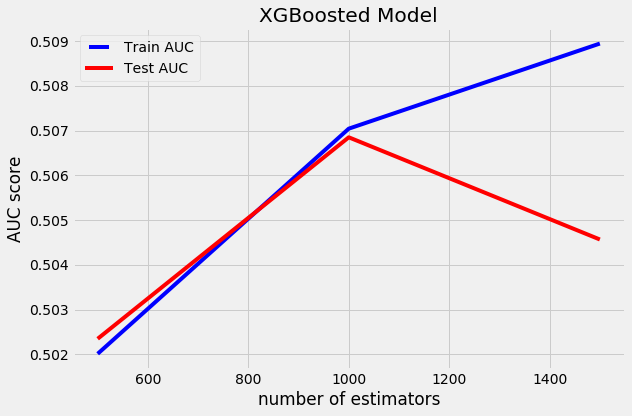

In [88]:
trees = [500, 1000, 1500]
train_results = []
test_results = []
for tree in trees:
    xgb = XGBClassifier(n_estimators=tree)
    xgb.fit(X_train, y_train)
    train_pred = xgb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = xgb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(figsize=(9, 6))
line1, = ax.plot([tree for tree in trees], train_results, 'b', label='Train AUC')
line2, = ax.plot([tree for tree in trees], test_results, 'r', label='Test AUC')
ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax.set_title('XGBoosted Model')
ax.set_ylabel('AUC score')
ax.set_xlabel('number of estimators')
fig.tight_layout()
plt.savefig('visuals/XGBntrees.png')

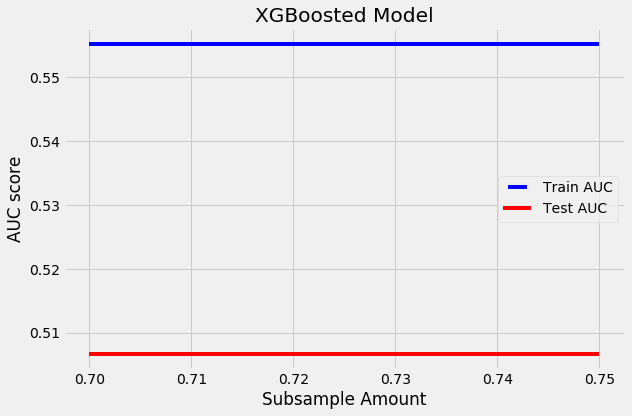

In [93]:
regs = np.linspace(.7, .75, 2, endpoint=True)
train_results = []
test_results = []
for reg in regs:
    xgb = XGBClassifier(subsample=reg, n_estimators=500, max_depth=10, n_jobs=-1)
    xgb.fit(X_train, y_train)
    train_pred = xgb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = xgb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(figsize=(9, 6))
line1, = ax.plot(regs, train_results, 'b', label='Train AUC')
line2, = ax.plot(regs, test_results, 'r', label='Test AUC')
ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax.set_title('XGBoosted Model')
ax.set_ylabel('AUC score')
ax.set_xlabel('Subsample Amount')
fig.tight_layout()
plt.savefig('visuals/XGBL1.png')

In [156]:
xgb = XGBClassifier(booster='dart', colsample_bynode=.3, colsample_bytree=.3, 
                    gamma=0, one_drop=1, 
                    learning_rate=0.05, max_delta_step=1, max_depth=8,
                    min_child_weight=1, n_estimators=1000, n_jobs=-1)

In [109]:
booster = xgb.fit(X_train, y_train, eval_metric='auc')

In [126]:
print ('Training Data | Fully-Tuned')
print_results(X_train, y_train, booster, .065)
print ('')
print ('Testing  Data | Fully-Tuned')
print_results(X_test, y_test, booster, .03)

Training Data | Fully-Tuned
  TP  |  FN  |  FP  |  TN  
--------------------------
   297|   200|   881| 17239
--------------------------
Recall:     0.5976
Precision:  0.2521
ROC_AUC:    0.7745

Testing  Data | Fully-Tuned
  TP  |  FN  |  FP  |  TN  
--------------------------
    79|   134|  1923|  5843
--------------------------
Recall:     0.3709
Precision:  0.0395
ROC_AUC:    0.5616


In [131]:
df = pd.read_csv('data/DataminingContest2009.Task2.Train.Inputs')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
y = pd.read_csv('data/DataminingContest2009.Task2.Train.Targets')
df.head()

,amount,hour1,state1,zip1,custAttr1,field1,custAttr2,field2,hour2,flag1,total,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5
0,12.95,0,WA,986,1234567890123456,0,luhxsodzmjhng7@comcast.net,0,0,0,12.95,-723,19,0,0,0,0,0,1
1,38.85,0,WA,980,1234567890123457,3,pfixyiqfpvkcg@zjyxs.net,1,0,0,38.85,5497,14,1,0,0,1,0,1
2,38.85,0,KY,402,1234567890123458,2,shbjoldciswwm@aol.com,1,0,0,38.85,-4420,23,0,0,1,1,0,1
3,12.95,0,CA,958,1234567890123459,3,ipbvtdfkhhfws@sbcglobal.net,0,0,0,12.95,5010,31,0,0,1,0,0,1
4,38.85,0,GA,300,1234567890123460,3,ivfuvxiennhdp@bellsouth.net,1,0,0,38.85,-4074,21,0,0,1,0,0,1


In [136]:
uhhhh = OneHotEncoder(drop='first').fit_transform(df[['field3', 'field4', 'amount', 'hour1']])

In [148]:
y.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [151]:
X_train, X_test, y_train, y_test = train_test_split(uhhhh, y.ravel(), random_state=7, test_size=.3, stratify=y)

In [152]:
booster = xgb.fit(X_train, y_train, eval_metric='auc')

In [186]:
print ('Training Data | Fully-Tuned')
print_results(X_train, y_train, booster, .08)
print ('')
print ('Testing  Data | Fully-Tuned')
print_results(X_test, y_test, booster, p=False)

Training Data | Fully-Tuned
  TP  |  FN  |  FP  |  TN  
--------------------------
   206|  1652|   939| 67202
--------------------------
Recall:     0.1109
Precision:  0.1799
ROC_AUC:    0.5485

Testing  Data | Fully-Tuned
  TP  |  FN  |  FP  |  TN  
--------------------------
     5|   791|     6| 29198
--------------------------
Recall:     0.006281
Precision:  0.4545
ROC_AUC:    0.5030


In [160]:
thresholds = np.linspace(.015, .045, 50)
scores = []
for thresh in thresholds:
    ROC = metrics.roc_auc_score(y_test, predict(booster, X_test, thresh))
    scores.append(ROC)

Text(0.5, 1.0, 'My Best Model :/')

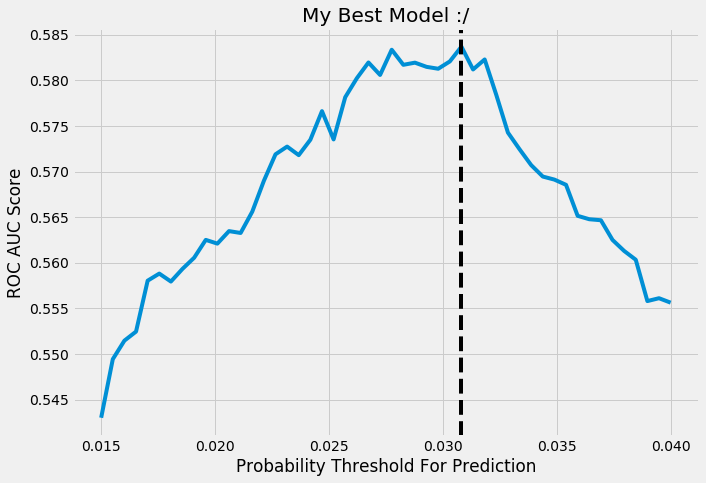

In [165]:
fig, ax = plt.subplots(figsize=(10, 7))
best_score = np.argmax(np.array(scores))
ax.axvline(thresholds[best_score], color='k', linestyle='--')

ax.plot(thresholds, scores)
ax.set_ylabel('ROC AUC Score')
ax.set_xlabel('Probability Threshold For Prediction')
ax.set_title('My Best Model :/')

In [163]:
thresholds[best_score]

0.030816326530612247

In [181]:
import scikitplot as skplt

In [190]:
probas = booster.predict_proba(X_test)

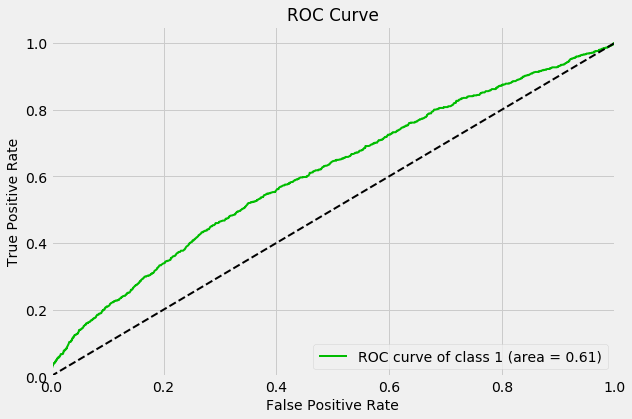

<Figure size 432x288 with 0 Axes>

In [197]:
skplt.metrics.plot_roc(y_test, probas, title='ROC Curve', plot_macro=False, plot_micro=False, figsize=(9, 6), classes_to_plot=[1])
plt.show()
plt.savefig('visuals/ROC.png')

In [191]:
probas

array([[0.98990494, 0.01009507],
       [0.97222805, 0.02777196],
       [0.98831195, 0.01168805],
       ...,
       [0.9725929 , 0.02740714],
       [0.9894712 , 0.01052877],
       [0.9866301 , 0.01336989]], dtype=float32)